In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Import ME PLEASE
import tensorflow as tf
import tensorflow_datasets as tfds
#pip install --upgrade tensorflow  
# now we use tensorflow 2 
#lets hope that your current libraries will not be destroyed :(
#if it happens, you can always downgrade it

## Download and preprocess

In [2]:
# The MNIST dataset is, in general, highly processed already - after all its 28x28 grayscale images 
# When finally deploying a model in practice, include the prerpocessing as initial layers!
# In that way, the users could just plug the data (images) directly, instead of being required to resize/rescale it before
# REMEMBER TRANSFER LEARNING SECTION,  you were able to send any size of picture to model

In [3]:
BUFFER_SIZE = 70_000 # for reshuffling
BATCH_SIZE = 128 # big batch size speeds up the training
#lower batch size can give better # use the power of 2.  as  2,4,8,32,64,128  (DESIRABLE---------I have dark desires to use 128 in a CNN, you thought something else :D)
NUM_EPOCHS = 3

In [4]:
# Download the MNIST dataset
# When 'with_info' is set to True, tfds.load() returns two variables: 
# - the dataset train and test
# - metadata

mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)
# mnist_dataset  data is here

In [5]:
# Extracting the train and test datasets
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test'] # obviously easy in MNIST

In [6]:
def scale(image, label):
    image = tf.cast(image, tf.float32) # cast it to float32 using tf
    image /= 255. # oh look its manual min max scaler for MATH FANS
# numbers vary 0 to 255 
# but we will scale this value between 0 to 1
    return image, label

In [7]:
 # scale me
train_and_validation_data = mnist_train.map(scale) # map everything to SCALE and SAVE
test_data = mnist_test.map(scale) # dont be scared, map()  applies your function to DATA

In [8]:
# Define the size of VALIDATION SET,  ( i recommend)
num_validation_samples = 0.1* mnist_info.splits['train'].num_examples  # 10% will be validation
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

In [9]:
# Define the size of TEST  SET
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64) # cast it to integer

In [10]:
# shuffle ( HOPEFULLY YOU REMEMBER)
train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)

In [11]:
# Splitting the dataset into training + validation
train_data = train_and_validation_data.skip(num_validation_samples) # dont return validation set
validation_data = train_and_validation_data.take(num_validation_samples) # take validation

In [12]:
# Batching the data
# dont take everything into memory take using BATCH, this is not a small dataset
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples) 
test_data = test_data.batch(num_test_samples)
#its for optimal performance

## Create the Super HOT XXX CNN Model

In [13]:

# CONV -> MAXPOOL -> CONV -> MAXPOOL -> FLATTEN -> DENSE
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation='relu', input_shape=(28, 28, 1)), # input size depends on data!
    
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),# (2,2) is the default pool size, if you leave it blank its gonna be 2,2
        #50 is, 50 kernels ( how many kernels im using)
    tf.keras.layers.Conv2D(50, 3, activation='relu'), # here is different kernel as 3x3
    #no need input shape again above!
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),  
    
    tf.keras.layers.Flatten(), # flatten everything
    tf.keras.layers.Dense(10) #apply softmax activation LATER for fully connected NN (EXPLAINED BELOW)
    #10 beacuse we have 10 classes!
])

In [14]:
# A brief summary of your CNN Model
model.summary(line_length = 75)
#why none in the first, because we use batch, we just pass thousands of images all at once
# but model does not know it yet, because we didnt train it NOT YET
#TRAINABLE PARAMETERS ARE WEIGHTS OF OUR NETWORK
#PERHAPS you would like to multiply your parameters by 2. ( this will be non-trainable, and we dont have it here)
# we have 22550 in second layer because, we are not concentrating on the spatial dimension but think
#of  its the third dimension of the input tensor

Model: "sequential"
___________________________________________________________________________
 Layer (type)                    Output Shape                  Param #     
 conv2d (Conv2D)                 (None, 24, 24, 50)            1300        
                                                                           
 max_pooling2d (MaxPooling2D)    (None, 12, 12, 50)            0           
                                                                           
 conv2d_1 (Conv2D)               (None, 10, 10, 50)            22550       
                                                                           
 max_pooling2d_1 (MaxPooling2D)  (None, 5, 5, 50)              0           
                                                                           
 flatten (Flatten)               (None, 1250)                  0           
                                                                           
 dense (Dense)                   (None, 10)                    12510

In [15]:
#USE softmatx into LOSS FUNCTION

# model needs to output probabilities of each class, 
# which can be achieved with a softmax activation in the last dense layer


# we use a loss calculation that automatically corrects for the missing softmax

# That is the reason for 'from_logits=True' #tells TF to use softmax into loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 

In [16]:
# Compile the model with ADAM optimizer and the categorical crossentropy (loss function)
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [17]:
# Defining early stopping to prevent overfitting if validation loss increases
early_stopping = tf.keras.callbacks.EarlyStopping(  #callback
    monitor = 'val_loss', # stops traininig when validation starts to increase for 2 subsequent epochs
    mode = 'auto',     # you can always change it
    min_delta = 0,
    patience = 2,
    verbose = 0, 
    restore_best_weights = True
)

In [18]:
# Train the network
model.fit(
    train_data, 
    epochs = NUM_EPOCHS, 
    callbacks = [early_stopping],   #callbacks are always here for you
    validation_data = validation_data,
    verbose = 2  #what to print during the training, 2 means print only at the end of epoch
    # verbose 1 will display progress bars for every batch
)

Epoch 1/3
422/422 - 42s - loss: 0.2716 - accuracy: 0.9206 - val_loss: 0.0878 - val_accuracy: 0.9720 - 42s/epoch - 99ms/step
Epoch 2/3
422/422 - 27s - loss: 0.0734 - accuracy: 0.9778 - val_loss: 0.0538 - val_accuracy: 0.9830 - 27s/epoch - 65ms/step
Epoch 3/3
422/422 - 27s - loss: 0.0538 - accuracy: 0.9835 - val_loss: 0.0362 - val_accuracy: 0.9892 - 27s/epoch - 65ms/step


## Testing

In [19]:
# Test your model
test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 1s 1s/step - loss: 0.0379 - accuracy: 0.9876


In [20]:
# print your hot content ( here is easy)
print('Test loss: {0:.4f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.0379. Test accuracy: 98.76%


### Results

In [21]:
import matplotlib.pyplot as plt
import numpy as np

In [22]:
# Spl test_data into 2 arrays, containing the images and their labels
for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

#Reshape images into 28x28 form, suitable for matplotlib because original dimensions were 28x28x1
images_plot = np.reshape(images_test, (10000,28,28))

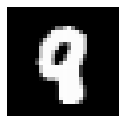

Label: 8


In [30]:
# The image to be displayed and tested
i = 589

# sad results below:
# i=34 bad result!!!
# i=589 will ruin this! (worst result)


# Plot the image
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="gray", aspect='auto')
plt.show()

# Print the correct label for the image
print("Label: {}".format(labels_test[i-1]))

<BarContainer object of 10 artists>

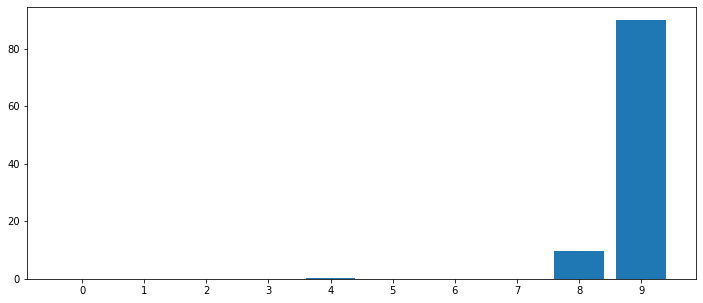

In [31]:
# Obtain the model's predictions probabilities
predictions = model.predict(images_test[i-1:i])

# Convert those predictions into probabilities (incorporate the softmax activation into the loss function)
probabilities = tf.nn.softmax(predictions).numpy()
# Convert the probabilities into percentages
probabilities = probabilities*100
# create your favorite barchart ( beautiful)
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])